In [309]:
# python3 
# version 1
# name: Zihan Ye

# datasets: 2015 September:
# green_tripdata_2015-09.csv

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from scipy.stats import lognorm

import warnings
warnings.filterwarnings("ignore")

In [311]:
#  Question 1
#  Programmatically download and load into your favorite analytical tool the trip data for September 2015.
#
#  Report how many rows and columns of data you have loaded.

In [312]:
df = pd.read_csv('green_tripdata_2015-09.csv') # import dataset from local disk
rows, columns = df.shape
# answer: 1494926 rows, 21 rows
print ('records rows: %d, colomns %d' %(rows, columns))

records rows: 1494926, colomns 21


In [313]:
# Question 2
# Plot a histogram of the number of the trip distance ("Trip Distance").
#
# Report any structure you find and any hypotheses you have about that structure.

In [314]:
df2 = df.copy()
trip_distance = df2['Trip_distance']
start = trip_distance.min()
dropoff = trip_distance.max()
median = trip_distance.median()

print ('The shortest trip distance is %d miles' %(start))
print ('The longest trip distance is %d miles' %(dropoff))

The shortest trip distance is 0 miles
The longest trip distance is 603 miles


In [315]:
# First all records trip distances are plot for histogram
# Also it is impossible that trip distance is 603 miles, that's approximate distance from NY to Columbia, South Carolina
# To omit outliers, set distance range within 20 miles. More than 99% trips finishes within 20 miles

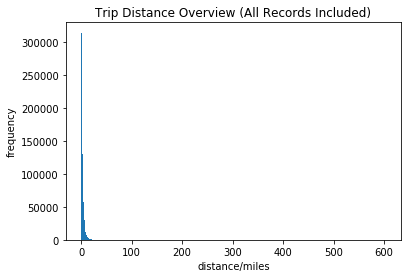

In [316]:
(n, bin, patches) = plt.hist(trip_distance, bins = 1000)
plt.title('Trip Distance Overview (All Records Included)')
plt.xlabel('distance/miles')
plt.ylabel('frequency')
plt.show()
plt.close()

In [317]:
# the following two pdf/cdf histograms show trip_distance shorter than 20.0 miles

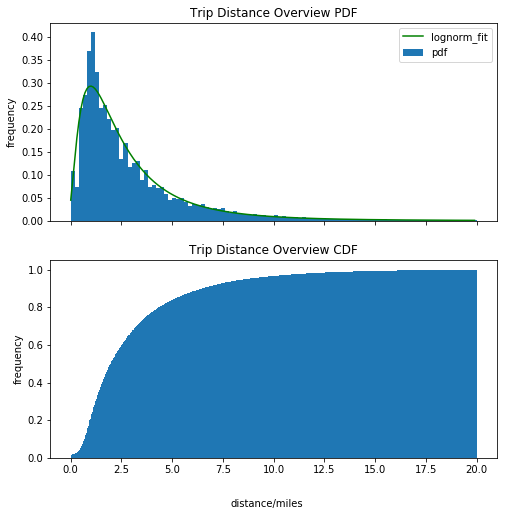

In [318]:

fig, ax = plt.subplots(2,1, sharex = True, figsize=(8,8))
ax[0].hist(trip_distance, normed = True, bins = 100, range = (0,20.0))
ax[1].hist(trip_distance, normed = True, bins = 1000, cumulative = True, range=(0, 20.0))

x = np.arange(0,20.0, 0.1)
scatter, loc, mean = lognorm.fit(trip_distance.values, trip_distance.mean(), loc=0)
ax[0].plot(x, lognorm.pdf(x,scatter, loc, mean), 'g')
ax[0].legend(['lognorm_fit', 'pdf'])
ax[0].set_title('Trip Distance Overview PDF')
ax[0].set_ylabel('frequency')
ax[1].set_title('Trip Distance Overview CDF')
ax[1].set_ylabel('frequency')

fig.text(0.5, 0.04, 'distance/miles', ha='center')
plt.show()

In [319]:
# Structure
# the frequency over trip distance is a lognormal distribution
# according to the pdf and cdf, most trip distances can be as short as within 10 miles

# Hypothesis:
# People choosing green cab mostly like are going to places within 10miles

In [320]:
# Question 3
# Report mean and median trip distance grouped by hour of day.

# We'd like to get a rough sense of identifying trips that originate
# or terminate at one of the NYC area airports.
# Can you provide a count of how many transactions fit this criteria,
# the average fair, and any other interesting characteristics of these trips.

In [321]:
df3 = df.copy()
df3['pickup_hour'] = pd.to_datetime(df3['lpep_pickup_datetime']).dt.hour
trip_distance_hour = df3.pivot_table(index = 'pickup_hour', values = 'Trip_distance', aggfunc = ('mean','median'))
print (trip_distance_hour)

                 mean  median
pickup_hour                  
0            3.115276    2.20
1            3.017347    2.12
2            3.046176    2.14
3            3.212945    2.20
4            3.526555    2.36
5            4.133474    2.90
6            4.055149    2.84
7            3.284394    2.17
8            3.048450    1.98
9            2.999105    1.96
10           2.944482    1.92
11           2.912015    1.88
12           2.903065    1.89
13           2.878294    1.84
14           2.864304    1.83
15           2.857040    1.81
16           2.779852    1.80
17           2.679114    1.78
18           2.653222    1.80
19           2.715597    1.85
20           2.777052    1.90
21           2.999189    2.03
22           3.185394    2.20
23           3.191538    2.22


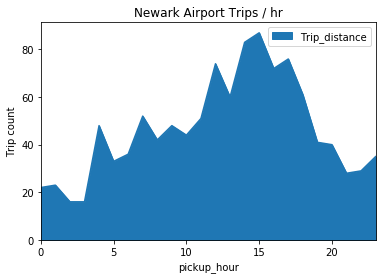

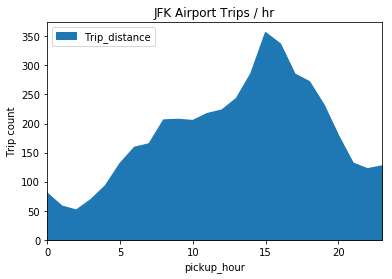

There are 1117 trips originate or terminate at Newark Airport, with average fare amount of $48.798568
There are 4435 trips originate or terminate at JFK Airport, with average fare amount of $49.021871


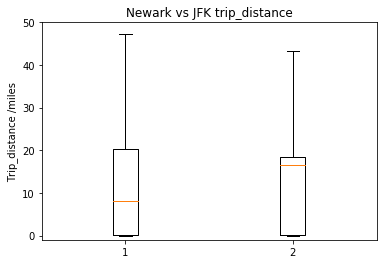

In [322]:
newark = df3.loc[df3['RateCodeID']==3]
newark_count = newark['Fare_amount'].count()
newark_average = newark['Fare_amount'].mean()
newark_pivot = newark.pivot_table(index = 'pickup_hour', values = 'Trip_distance', aggfunc = ('count'))
newark_pivot.plot(kind = 'area')
plt.ylabel('Trip count')
plt.title('Newark Airport Trips / hr')
plt.show()

JFK = df3.loc[df3['RateCodeID']==2]
JFK_count = JFK['Fare_amount'].count()
JFK_average = JFK['Fare_amount'].mean()
JFK_pivot = JFK.pivot_table(index = 'pickup_hour', values = 'Trip_distance', aggfunc = ('count'))
JFK_pivot.plot(kind = 'area')
plt.ylabel('Trip count')
plt.title('JFK Airport Trips / hr')
plt.show()

print ('There are %d trips originate or terminate at Newark Airport, with average fare amount of $%f'%(newark_count, newark_average))
print ('There are %d trips originate or terminate at JFK Airport, with average fare amount of $%f'%(JFK_count, JFK_average))

data = [list(newark['Trip_distance']), list(JFK['Trip_distance'])]
plt.boxplot(data)
plt.ylim([-1, 50])
plt.ylabel('Trip_distance /miles')
plt.title('Newark vs JFK trip_distance')
plt.show()

In [323]:
# More trips were to JFK airport than to Newark Airport, although trips distances made originated/terminate at JFK
# airport are in average longer than those made at Newark.
# There might give a hypothesis that JFK airport is more busy than Newark airport.

# Another discovery is that there is consistency in both airports cases 
# that the most trips were made to airports at around 15:00

In [324]:
# Question 4
# Build a derived variable for tip as a percentage of the total fare.
# Build a predictive model for tip as a percentage of the total fare.
# Use as much of the data as you like (or all of it). We will validate a sample.

In [325]:
df4 = df.copy()
rows, columns = df4.shape

df4 = df4.loc[df4['Total_amount']>2.5] # because all initial charge is $2.5
df4['Tip_percentage'] = 100* df4['Tip_amount'] / df4['Total_amount']
print (df4['Tip_percentage'].describe())

count    1.487749e+06
mean     6.666013e+00
std      8.875859e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e+01
max      1.000000e+02
Name: Tip_percentage, dtype: float64


In [326]:
# Building a predictive model
# I first researched that which features might have influences on tip_amount decisions
# According to dataset description: Tip amount – This field is automatically populated for credit card
# tips. Cash tips are not included. Thus tip_amount is influenced by payment method and I used histogram to
# see tip_percentage distribution for payment methods. The last payment method: Voided trips, does not exist
# after filtered
# The discovery indicates that, for payment methods except, credit card, 
# tip_percentage is negligible.

# Another important discovery useful for next step investigation:
# With credit card payment, most people chose to pay 15-20% amount of tips, also lots of people payment almost 0%.

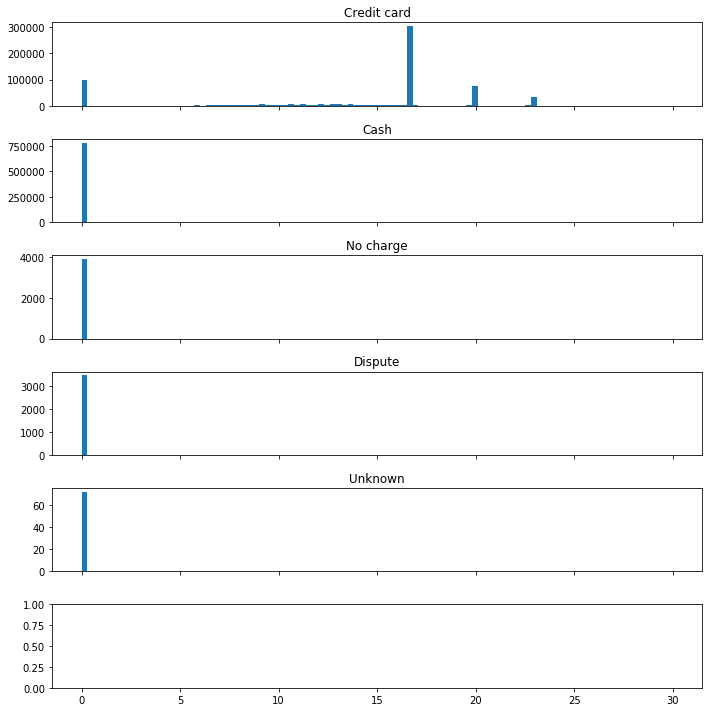

In [327]:
fig, ax = plt.subplots(6,1, sharex = True,  figsize=(10,10))
payment = ['Credit card', 'Cash', 'No charge', 'Dispute', 'Unknown', 'Voided trip']
index = 0
for name, group in df4.groupby('Payment_type'):
    ax[index].hist(group['Tip_percentage'], bins = 100, label = str(name), range = (.0, 30.0))
    ax[index].set_title(payment[index])
    index +=1
plt.tight_layout()
plt.show()
plt.close()

In [328]:
# Continued:
# I decided to only look into records with payment_type as credit card
# I thought that there is relationship between trip distances and tips percentage, saying that
# the longer the trip, more likely, people will give more tips.
# I specifically looked into three groups with tips percentage within [0,3], [15,18], [18,21], because most records fall
# within them.

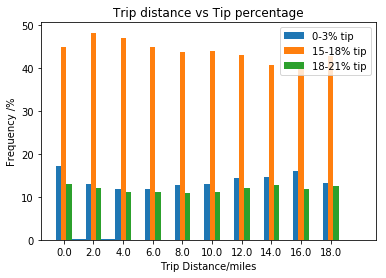

In [329]:
bin_number = 10
credit_card = df4.loc[df4['Payment_type']==1 ]
(n, bin, patches) = plt.hist(credit_card['Trip_distance'], normed=True, bins = bin_number, range=(0,20.0))


def tip_plot(min_distance, max_distance, dataset, variable):
    distance_payment = dataset.loc[
    (np.float64(max_distance) > dataset[variable]) & (np.float64(min_distance) <= dataset[variable])]
    return distance_payment


zero_percentage = []
fifteen_percentage = []
twenty_percentage = []

bar_width = 0.35
fig, ax = plt.subplots(bin_number,1, sharex = True)
for index in range(bin_number):
    min_distance = bin[index]
    max_distance = bin[index+1]
    credit_card_distance = tip_plot(min_distance, max_distance, credit_card, 'Trip_distance')
    credit_tip_distance = credit_card_distance['Tip_percentage']
    total = credit_tip_distance.count()
    (n, bin_value, patches) = ax[index].hist(credit_tip_distance, bins = bin_number, range = (0.0, 30.0))
    zero_percentage.append(100* n[0]/total)
    fifteen_percentage.append(100* n[5]/total)
    twenty_percentage.append(100* n[6]/total)
plt.close()

plt.bar(bin[:-1]-bar_width, zero_percentage, bar_width, label = '0-3% tip')
plt.bar(bin[:-1], fifteen_percentage,bar_width, label = '15-18% tip')
plt.bar(bin[:-1]+bar_width, twenty_percentage, bar_width, label = '18-21% tip')
plt.xlabel('Trip Distance/miles')
plt.ylabel('Frequency /%')
plt.xticks(bin[:-1], bin[:-1])
plt.legend()
plt.title('Trip distance vs Tip percentage')
plt.show()
plt.close()

In [330]:
# from the above bar plot, at any trip distance interval, most people tend to give 15-18% tips
# thus, this observation rejects my hypothesis. 
# Thus, trip distance does not greatly affect tip_percentage 

In [331]:
# Next, I thought trip duration might affect people's tip decision as well
# I looked into relationship between trip duration and tip_percentage

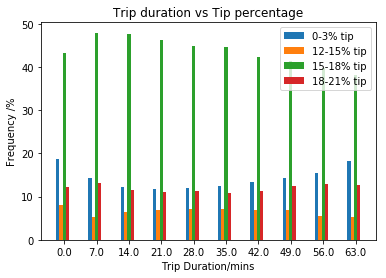

In [332]:
time_duration = df4.loc[df['Payment_type']==1]
time_duration['pickup_hour'] = pd.to_datetime(time_duration['lpep_pickup_datetime']).dt.hour
time_duration['dropoff_hour'] = pd.to_datetime(time_duration['Lpep_dropoff_datetime']).dt.hour
time_duration['Duration'] = pd.to_datetime(time_duration['Lpep_dropoff_datetime']) - pd.to_datetime(time_duration['lpep_pickup_datetime'])
time_duration['Duration'] = time_duration['Duration'].astype('timedelta64[m]')

x = time_duration['Duration']
# more than 99% trips finished within 70mins
(n, bin_duration, patches) = plt.hist(time_duration['Duration'], bins = 10, range = (0.0, 70.0))
plt.close()

zero_percentage = []
twelve_percentage = []
fifteen_percentage = []
twenty_percentage = []

fig, ax = plt.subplots(10,1, sharex = True)
for index in range(bin_number):
    min_duration = bin_duration[index]
    max_duration = bin_duration[index+1]
    credit_tip_dur = tip_plot(min_duration, max_duration, time_duration, 'Duration')
    credit_tip_duration = credit_tip_dur['Tip_percentage']
    total = credit_tip_duration.count()
    (n, bin_value, patches) = ax[index].hist(credit_tip_duration, bins=bin_number, range=(0.0, 30.0))
    zero_percentage.append(100*n[0]/total)
    twelve_percentage.append(100*n[4]/total)
    fifteen_percentage.append(100*n[5]/total)
    twenty_percentage.append(100*n[6]/total)

plt.close()
plt.bar(bin_duration[:-1]-4*bar_width, zero_percentage, 2*bar_width, label = '0-3% tip')
plt.bar(bin_duration[:-1]-2*bar_width, twelve_percentage, 2*bar_width, label = '12-15% tip')
plt.bar(bin_duration[:-1], fifteen_percentage,2*bar_width, label = '15-18% tip')
plt.bar(bin_duration[:-1]+2*bar_width, twenty_percentage, 2*bar_width, label = '18-21% tip')
plt.xlabel('Trip Duration/mins')
plt.ylabel('Frequency /%')
plt.xticks(bin_duration[:-1], bin_duration[:-1])
plt.legend(loc = 'upper right')
plt.title('Trip duration vs Tip percentage')
plt.show()
plt.close()

In [333]:
# from the above bar plot, at any trip duration interval, most people tend to give 15-18% tips 
# Thus, trip duration does not greatly affect tip_percentage 

# besides, features [Trip duration, trip distance, payment method], I also looked into other features, such as
# pickup/dropoff hours, passenger number, trip type and etc. They have negligible impact on tip_percentage

In [334]:
# From exploratory data analysis, it is hard to find any feature that greatly affect people's decision on which percentage
# tips they want to give.
# But these features might contribute to decide whether people give tips or not
# The following predictive model aims to predict whether people give tips or not and this becomes a binary problem
# I used a logistic regression model

In [335]:
model = df.copy()
rows, columns = model.shape

# clean and order the whole dataset
model['pickup_hour'] = pd.to_datetime(model['lpep_pickup_datetime']).dt.hour
model['dropoff_hour'] = pd.to_datetime(model['Lpep_dropoff_datetime']).dt.hour
model['Duration'] = pd.to_datetime(model['Lpep_dropoff_datetime']) - pd.to_datetime(model['lpep_pickup_datetime'])
model['Duration'] = model['Duration'].astype('timedelta64[m]') 

In [336]:
# the tip_amount less than $0.01 is treated as not paid

In [337]:
model['PayOrNot'] = (model['Tip_amount'] < 0.01)
label = model['PayOrNot'] # make into a binary problem: tips paid vs tips not paid

features = ['Payment_type','Trip_distance', 'Duration']
x_tips = model[features]
y_tips = label

x_train, x_test, y_train, y_test = train_test_split(x_tips.as_matrix(), y_tips.as_matrix(),random_state = 0)
clf1 = LogisticRegression().fit(x_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(clf1.score(x_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'.format(clf1.score(x_test, y_test)))

# Cross-Validation
from sklearn.model_selection import cross_val_score
clf2 = LogisticRegression(C=100)
cv_scores = cross_val_score(clf2, x_tips, y_tips, cv = 5)

print('Cross-validation scores (5-fold):', cv_scores)
print('Mean cross-validation score (5-fold): {:.3f}'.format(np.mean(cv_scores)))

Accuracy of Logistic regression classifier on training set: 0.93
Accuracy of Logistic regression classifier on test set: 0.93
Cross-validation scores (5-fold): [ 0.93576957  0.9337193   0.93304346  0.93467231  0.93314023]
Mean cross-validation score (5-fold): 0.934


In [338]:
# prediction function:
# input: raw - groups of records, features, and logistic regression handler
# output: predict result and its true label

In [343]:
def predict(records, features, clf):
    records['pickup_hour'] = pd.to_datetime(records['lpep_pickup_datetime']).dt.hour
    records['dropoff_hour'] = pd.to_datetime(records['Lpep_dropoff_datetime']).dt.hour
    records['Duration'] = pd.to_datetime(records['Lpep_dropoff_datetime']) - pd.to_datetime(records['lpep_pickup_datetime'])
    records['Duration'] = records['Duration'].astype('timedelta64[m]') 
    
    records['PayOrNot'] = (records['Tip_amount'] < 0.01)
    label = records['PayOrNot']
    x_tips = records[features]
    predict_result = clf.predict(x_tips)
    print (predict_result)
    print (label)
    

In [344]:
# Example:

In [345]:
record = df.loc[2:5]
pd.to_datetime(record['lpep_pickup_datetime']).dt.hour
predict(record, features, clf1)

[False  True  True False]
2    False
3     True
4     True
5    False
Name: PayOrNot, dtype: bool


In [346]:
# Question 5
# Option A: Distributions
#   Build a derived variable representing the average speed over the course of a trip.
#   Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September?
#   If you decide they are not the same, can you form a hypothesis regarding why they differ?
#   Can you build up a hypothesis of average trip speed as a function of time of day?

In [347]:
# prepare the dataset:
# change to hours as duration unit
# delete outliers: more than 99% trips finish is within 5 hours ; 
# more than 99% trips courses speed is within 40.0mph

In [348]:
df5 = df.copy()

df5['pickup_hour'] = pd.to_datetime(df5['lpep_pickup_datetime']).dt.hour
df5['dropoff_hour'] = pd.to_datetime(df5['Lpep_dropoff_datetime']).dt.hour
df5['Duration'] = pd.to_datetime(df5['Lpep_dropoff_datetime']) - pd.to_datetime(df5['lpep_pickup_datetime'])
df5['Duration'] = df5['Duration'].astype('timedelta64[h]')

df5 = df5.loc[df5['Duration'] > 0.0]
df5_pickup = df5.copy() # for next hypothesis use
df5 = df5.loc[df5['Duration'] < 5.0] 
df5['average_speed'] = df5['Trip_distance'] / df5['Duration']
df5 = df5.loc[df5['average_speed'] < 40.0]

print (df5['average_speed'].describe())

count    7495.000000
mean       12.160700
std         7.103379
min         0.000000
25%         7.360000
50%        11.550000
75%        16.400000
max        39.610000
Name: average_speed, dtype: float64


the average speed of trips is: 12.161


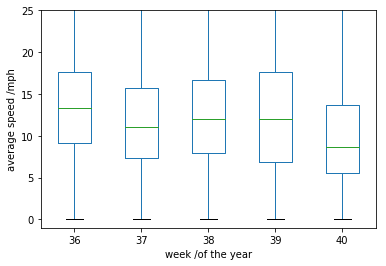

In [349]:
df5['week'] = pd.to_datetime(df5['lpep_pickup_datetime']).dt.week
weekly_speed = df5.pivot_table(index = df5.index, columns = 'week', values = 'average_speed')
print ('the average speed of trips is: {:.3f}'.format(df5['average_speed'].mean()))
weekly_speed.plot(kind = 'box')
plt.ylim([-1,25])
plt.xlabel('week /of the year')
plt.ylabel('average speed /mph')
plt.show()

In [350]:
week_number = pd.unique(df5['week'])
print (week_number)

[36 37 38 39 40]


In [351]:
from scipy.stats import ttest_ind
week_number = []
week_speed = {}
for name, group in df5.groupby('week'):
    week_number.append(name)
    week_speed[name]=list(group['average_speed'])
    
for i in week_number:
    for j in week_number:
        t_value, p_value = ttest_ind(week_speed[i], week_speed[j], equal_var=False)
        print (i, j, 't-value: %g,    p-value: %g' %(t_value, p_value))

36 36 t-value: 0,    p-value: 1
36 37 t-value: 7.29664,    p-value: 4.23113e-13
36 38 t-value: 4.67409,    p-value: 3.13003e-06
36 39 t-value: 3.57302,    p-value: 0.000360304
36 40 t-value: 11.2562,    p-value: 1.50565e-28
37 36 t-value: -7.29664,    p-value: 4.23113e-13
37 37 t-value: 0,    p-value: 1
37 38 t-value: -2.91691,    p-value: 0.00355481
37 39 t-value: -2.57118,    p-value: 0.0102079
37 40 t-value: 6.14391,    p-value: 9.95997e-10
38 36 t-value: -4.67409,    p-value: 3.13003e-06
38 37 t-value: 2.91691,    p-value: 0.00355481
38 38 t-value: 0,    p-value: 1
38 39 t-value: -0.341301,    p-value: 0.73291
38 40 t-value: 8.14457,    p-value: 6.73906e-16
39 36 t-value: -3.57302,    p-value: 0.000360304
39 37 t-value: 2.57118,    p-value: 0.0102079
39 38 t-value: 0.341301,    p-value: 0.73291
39 39 t-value: 0,    p-value: 1
39 40 t-value: 7.07915,    p-value: 1.96408e-12
40 36 t-value: -11.2562,    p-value: 1.50565e-28
40 37 t-value: -6.14391,    p-value: 9.95997e-10
40 38 t-valu

In [360]:
# null hypothesis is that all samples have the same average
# apparently from p-values obtained from t-test, null hypothesis is rejected
# One raw observation from average speed over weeks of september is that:
# the average speed is relatively faster at month beginning and relatively slower at month end
# we can further investigate into October and August's data to see there is a consistency in this observation 

In [361]:
df5_pickup = df5_pickup.loc[df5_pickup['Duration'] < 2.0]
df5_pickup['average_speed'] = df5_pickup['Trip_distance'] / df5_pickup['Duration']
df5_pickup = df5_pickup.loc[df5_pickup['average_speed'] < 35.0]

pickup_average_speed = df5_pickup.pivot_table(index = df5_pickup.index, columns = 'pickup_hour', values = 'average_speed')
pickup_average_speed.plot(kind = 'box')
plt.ylim([-1, 40])
plt.xlabel('hour')
plt.ylabel('average speed/mph')

In [362]:
# average trip speed as a function of the day
# hypothesis: average speed is faster during late night, between [22:00, 3:00], when normally there is no traffic
#             average speed is lower during morning, between [6:00, 11:00], when normally there is lots of traffic

           5           4          3         2
9.963e-05 x - 0.00652 x + 0.1532 x - 1.505 x + 5.071 x + 13.28


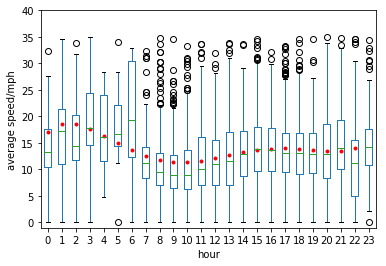

In [363]:
pickup_hr = []
pickup_speed = []
for name, group in df5_pickup.groupby('pickup_hour'):
    pickup_hr.append(name)
    pickup_speed.append(group['average_speed'].mean())
    
degree = 5
z = np.polyfit(pickup_hr, pickup_speed, degree)
p_degree = np.poly1d(z)
print (p_degree)
plt.plot(pickup_hr, p_degree(pickup_hr), 'r.')
plt.show()